In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from rex import init_logger
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import spaces
from gymnasium.vector.utils.spaces import batch_space
from stable_baselines3.common.env_checker import check_env
from sympy import symbols
from rl_equation_solver.utilities.history import History
import torch
from sympy import parse_expr

In [3]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.best_history["reward"])
    ax.set_ylabel("Count")
    ax.set_xlabel("Reward")
    plt.show()


# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history
    x = np.arange(len(history["ep"]))

    y = history["complexity"]
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a * x + b, color="r")

    y = history["loss"]
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a * x[mask] + b, color="r")

    y = history["reward"]
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a * x + b, color="r")

    y = history["loop_step"]
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a * x + b, color="r")

    ax[0].set_title("Complexity")
    ax[1].set_title("Loss")
    ax[2].set_title("Reward")
    ax[3].set_title("Steps")

    plt.show()

In [4]:
init_logger(__name__, log_level="DEBUG")
init_logger("rl_equation_solver", log_level="DEBUG")

<Logger rl_equation_solver (DEBUG)>

In [5]:
env = Env(order=2)

INFO - 2023-04-21 14:52:10,842 [algebraic.py:106] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-21 14:52:10,843 [algebraic.py:109] : Using reward function: diff_loss_reward.


In [6]:
check_env(env, warn=True)

DEBUG - 2023-04-21 14:52:11,275 [algebraic.py:443] : {'ep': '0   ', 'step': '0   ', 'loop_step': '0   ', 'complexity': '1.50e+01 ', 'loss': 'nan      ', 'reward': '-6.00e+00', 'previous_state': '0                   ', 'state': 'a1                  '}
DEBUG - 2023-04-21 14:52:11,316 [algebraic.py:443] : {'ep': '0   ', 'step': '1   ', 'loop_step': '1   ', 'complexity': '2.80e+01 ', 'loss': 'nan      ', 'reward': '-1.30e+01', 'previous_state': 'a1                  ', 'state': '-a0 + a1            '}
DEBUG - 2023-04-21 14:52:11,367 [algebraic.py:443] : {'ep': '0   ', 'step': '2   ', 'loop_step': '2   ', 'complexity': '2.20e+01 ', 'loss': 'nan      ', 'reward': '6.00e+00 ', 'previous_state': '-a0 + a1            ', 'state': '-a0                 '}
DEBUG - 2023-04-21 14:52:11,398 [algebraic.py:443] : {'ep': '0   ', 'step': '3   ', 'loop_step': '3   ', 'complexity': '1.20e+01 ', 'loss': 'nan      ', 'reward': '1.00e+01 ', 'previous_state': '-a0                 ', 'state': '-1                 

In [7]:
model = DQN("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
model.set_env(env)
model.learn(total_timesteps=int(10000))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
DEBUG - 2023-04-21 14:52:13,771 [algebraic.py:443] : {'ep': '0   ', 'step': '11  ', 'loop_step': '0   ', 'complexity': '1.70e+01 ', 'loss': 'nan      ', 'reward': '-8.00e+00', 'previous_state': '0                   ', 'state': 'a0                  '}
DEBUG - 2023-04-21 14:52:13,817 [algebraic.py:443] : {'ep': '0   ', 'step': '12  ', 'loop_step': '1   ', 'complexity': '2.60e+01 ', 'loss': 'nan      ', 'reward': '-9.00e+00', 'previous_state': 'a0                  ', 'state': 'a0 - 1              '}
DEBUG - 2023-04-21 14:52:13,875 [algebraic.py:443] : {'ep': '0   ', 'step': '13  ', 'loop_step': '2   ', 'complexity': '3.20e+01 ', 'loss': 'nan      ', 'reward': '-6.00e+00', 'previous_state': 'a0 - 1              ', 'state': 'a0 + a1 - 1         '}
DEBUG - 2023-04-21 14:52:13,919 [algebraic.py:443] : {'ep': '0   ', 'step': '14  ', 'loop_step': '3   ', 'complexity': '2.30e+01 ', 'loss': 'nan      ', 'reward': '9.00e+

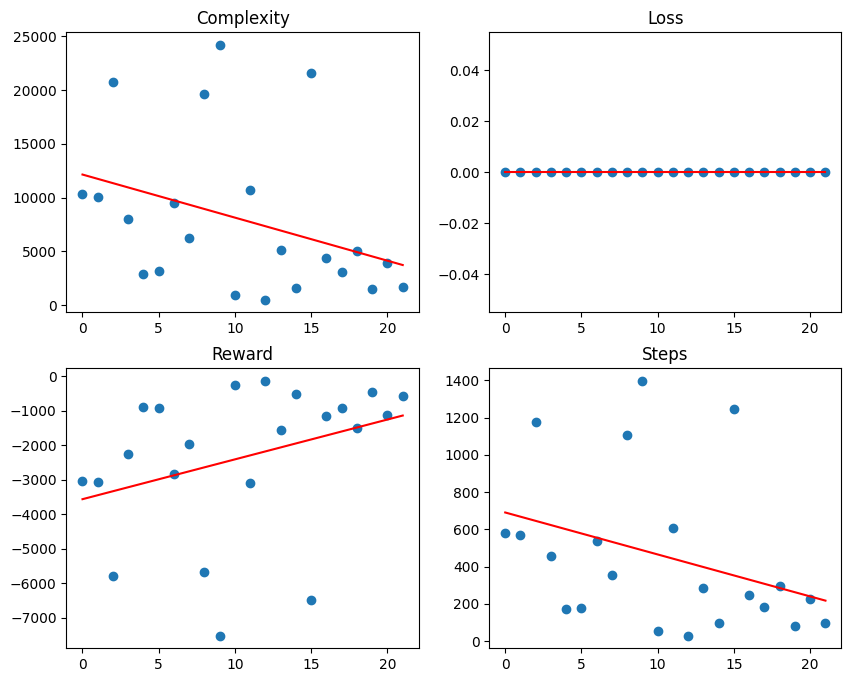

In [10]:
plot_trends(env)